## Data Loading

In [3]:
# Step 1: Load and Explore EEG Pain Dataset segments_raw_1000hz_v2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os

# Set dataset root path
root = '/EEG Pain Estimation/data'

# --- Load index.csv ---
index_path = f'{root}/index.csv'
if not os.path.exists(index_path):
    raise FileNotFoundError(f"index.csv not found in {root}")

index_df = pd.read_csv(index_path)
print("Total epochs:", len(index_df))
print(index_df.head())

# --- Check and clean invalid / rejected entries ---
if 'reject_flag' in index_df.columns:
    print(f"Found 'reject_flag' column. Removing rejected epochs...")
    clean_df = index_df[index_df['reject_flag'] == False].copy()
else:
    print("'reject_flag' column not found — using full dataset.")
    clean_df = index_df.copy()

if len(clean_df) == 0:
    print("No valid rows found after filtering. Reverting to full dataset.")
    clean_df = index_df.copy()

print("Clean epochs after filtering:", len(clean_df))

Total epochs: 80282
                               path participant session stimulus_code  \
0   sub-001_ses-1_S18_85554_erp.npz     sub-001   ses-1          S 18   
1  sub-001_ses-1_S18_111637_erp.npz     sub-001   ses-1          S 18   
2  sub-001_ses-1_S18_258152_erp.npz     sub-001   ses-1          S 18   
3  sub-001_ses-1_S18_374867_erp.npz     sub-001   ses-1          S 18   
4  sub-001_ses-1_S18_491584_erp.npz     sub-001   ses-1          S 18   

  stimulus_category  pain_rating rating_bin window   sfreq  n_channels  \
0       Non-painful          0.2       none    erp  1000.0          64   
1       Non-painful          0.1       none    erp  1000.0          64   
2       Non-painful          0.0       none    erp  1000.0          64   
3       Non-painful          0.0       none    erp  1000.0          64   
4       Non-painful          0.3       none    erp  1000.0          64   

   n_times  reject_flag  
0     1001        False  
1     1001        False  
2     1001        

In [11]:
index_df.head()

,path,participant,session,stimulus_code,stimulus_category,pain_rating,rating_bin,window,sfreq,n_channels,n_times,reject_flag
0,sub-001_ses-1_S18_85554_erp.npz,sub-001,ses-1,S 18,Non-painful,0.2,none,erp,1000.0,64,1001,False
1,sub-001_ses-1_S18_111637_erp.npz,sub-001,ses-1,S 18,Non-painful,0.1,none,erp,1000.0,64,1001,False
2,sub-001_ses-1_S18_258152_erp.npz,sub-001,ses-1,S 18,Non-painful,0.0,none,erp,1000.0,64,1001,False
3,sub-001_ses-1_S18_374867_erp.npz,sub-001,ses-1,S 18,Non-painful,0.0,none,erp,1000.0,64,1001,False
4,sub-001_ses-1_S18_491584_erp.npz,sub-001,ses-1,S 18,Non-painful,0.3,none,erp,1000.0,64,1001,False


In [18]:
index_df["window"].unique()

array(['erp', 'post', 'baseline'], dtype=object)

In [12]:
index_df.shape

(80282, 12)

In [4]:
# What does stimulus category mean?
# Unique: ['Non-painful', 'Painful', 'High Pain']
index_df['pain_rating'].unique()

array([ 0.2,  0.1,  0. ,  0.3,  0.4,  1. ,  0.8,  0.7,  1.1,  0.9,  1.5,
        1.6,  1.2,  2.1,  2. ,  5.5,  3.5,  5.7,  5.2,  3.8,  1.9,  3.3,
        5.1,  9.7,  7.7,  7.8,  8.5,  8.6, 10. ,  7. ,  1.3,  1.4,  2.8,
        2.2,  3. ,  4.1,  4.8,  4.3,  5.4,  3.7,  6.2,  9.6,  6.1,  9.3,
        7.2,  8.1,  1.7,  0.5,  1.8,  2.3,  2.5,  2.9,  4.7,  3.2,  6.4,
        6.3,  8.3,  6.7,  8.2,  8. ,  9.9,  8.8,  8.9,  2.4,  4.2,  4.6,
        4.5,  7.1,  9.4,  7.4,  7.3,  5.9,  2.7,  9.1,  9.2,  3.1,  6.8,
        3.4,  6. ,  8.7,  9. ,  2.6,  3.9,  7.5,  7.6,  0.6,  5.8,  4. ,
        3.6,  5.3,  6.5,  8.4,  5.6,  4.4,  4.9,  9.8,  6.9,  5. ,  7.9,
        6.6,  9.5])

## Data Visualization and analysis

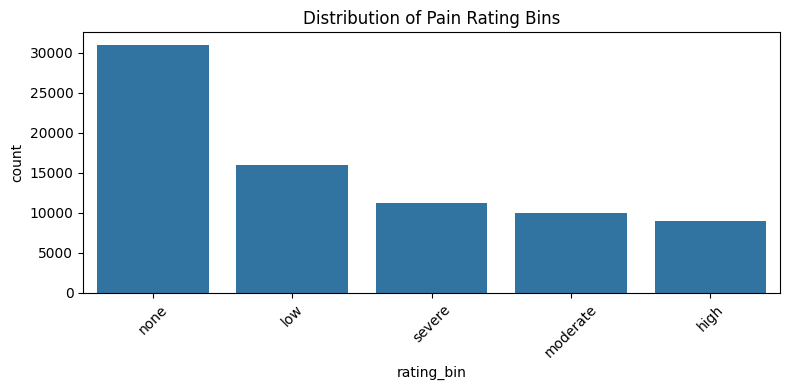

In [5]:
# --- Distribution of pain categories ---
plt.figure(figsize=(8, 4))
sns.countplot(data=clean_df, x='rating_bin', order=clean_df['rating_bin'].value_counts().index)
plt.title("Distribution of Pain Rating Bins")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

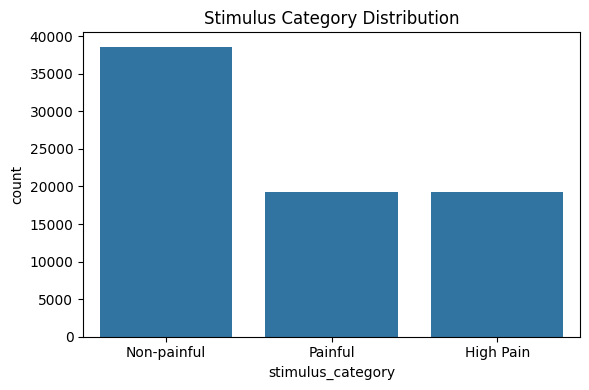

In [6]:
# --- Distribution of stimulus types ---
if 'stimulus_category' in clean_df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=clean_df, x='stimulus_category')
    plt.title("Stimulus Category Distribution")
    plt.tight_layout()
    plt.show()
else:
    print("'stimulus_category' column not found in CSV")


In [7]:

example = clean_df.sample(1, random_state=42).iloc[0]

npz_path = f"{root}/npz/{example['path']}"
if not os.path.exists(npz_path):
    raise FileNotFoundError(f"EEG .npz file not found: {npz_path}")

npz = np.load(npz_path, allow_pickle=True)
X = npz['X']  # shape: (channels, time)
ch_names = npz['ch_names']

print(f"Example EEG shape: {X.shape} (channels × time)")
print(f"Channels available: {len(ch_names)}")

Example EEG shape: (64, 1001) (channels × time)
Channels available: 64


## Data extraction

In [8]:
import os
from tqdm import tqdm
import numpy as np
from scipy.signal import stft
from collections import Counter

fs = 1000
nperseg = 256 
noverlap = 128

def compute_spectrogram(X, fs=1000, nperseg=256, noverlap=128):
    specs = []
    for ch in range(X.shape[0]):
        f, t, Zxx= stft(X[ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
        specs.append(np.abs(Zxx))
    return np.stack(specs, axis=0)

features, labels, ch_counts = [], [], []

# Pass 1 — find most common channel count
for i, row in tqdm(clean_df.iterrows(), total=len(clean_df), desc="Scanning channels"):
    npz_path = os.path.join(root, 'npz', row['path'])
    if not os.path.exists(npz_path):
        continue
    npz = np.load(npz_path, allow_pickle=True)
    ch_counts.append(npz['X'].shape[0])

most_common_channels = Counter(ch_counts).most_common(1)[0][0]
print(f"Most common channel count: {most_common_channels}")

# Pass 2 — extract features only from those epochs
for i, row in tqdm(clean_df.iterrows(), total=len(clean_df), desc="Extracting features"):
    npz_path = os.path.join(root, 'npz', row['path'])
    if not os.path.exists(npz_path):
        continue
    npz = np.load(npz_path, allow_pickle=True)
    X = npz['X']

    # Skip files with mismatched channel count
    if X.shape[0] != most_common_channels:
        continue

    spec = compute_spectrogram(X, fs, nperseg, noverlap)
    mean_feat = np.mean(spec, axis=(1, 2))
    std_feat = np.std(spec, axis=(1, 2))
    feat = np.concatenate([mean_feat, std_feat])
    features.append(feat)
    labels.append(row['rating_bin'])

# Convert to arrays safely
X_features = np.vstack(features)
y_labels = np.array(labels)

print(" Feature matrix shape:", X_features.shape)
print(" Labels:", np.unique(y_labels, return_counts=True))

Scanning channels: 100%|██████████| 77190/77190 [02:30<00:00, 513.39it/s]


Most common channel count: 64


Extracting features: 100%|██████████| 77190/77190 [06:16<00:00, 204.86it/s]

 Feature matrix shape: (75700, 128)
 Labels: (array(['high', 'low', 'moderate', 'none', 'severe'], dtype='<U8'), array([ 8776, 15687,  9835, 30391, 11011]))


## Results


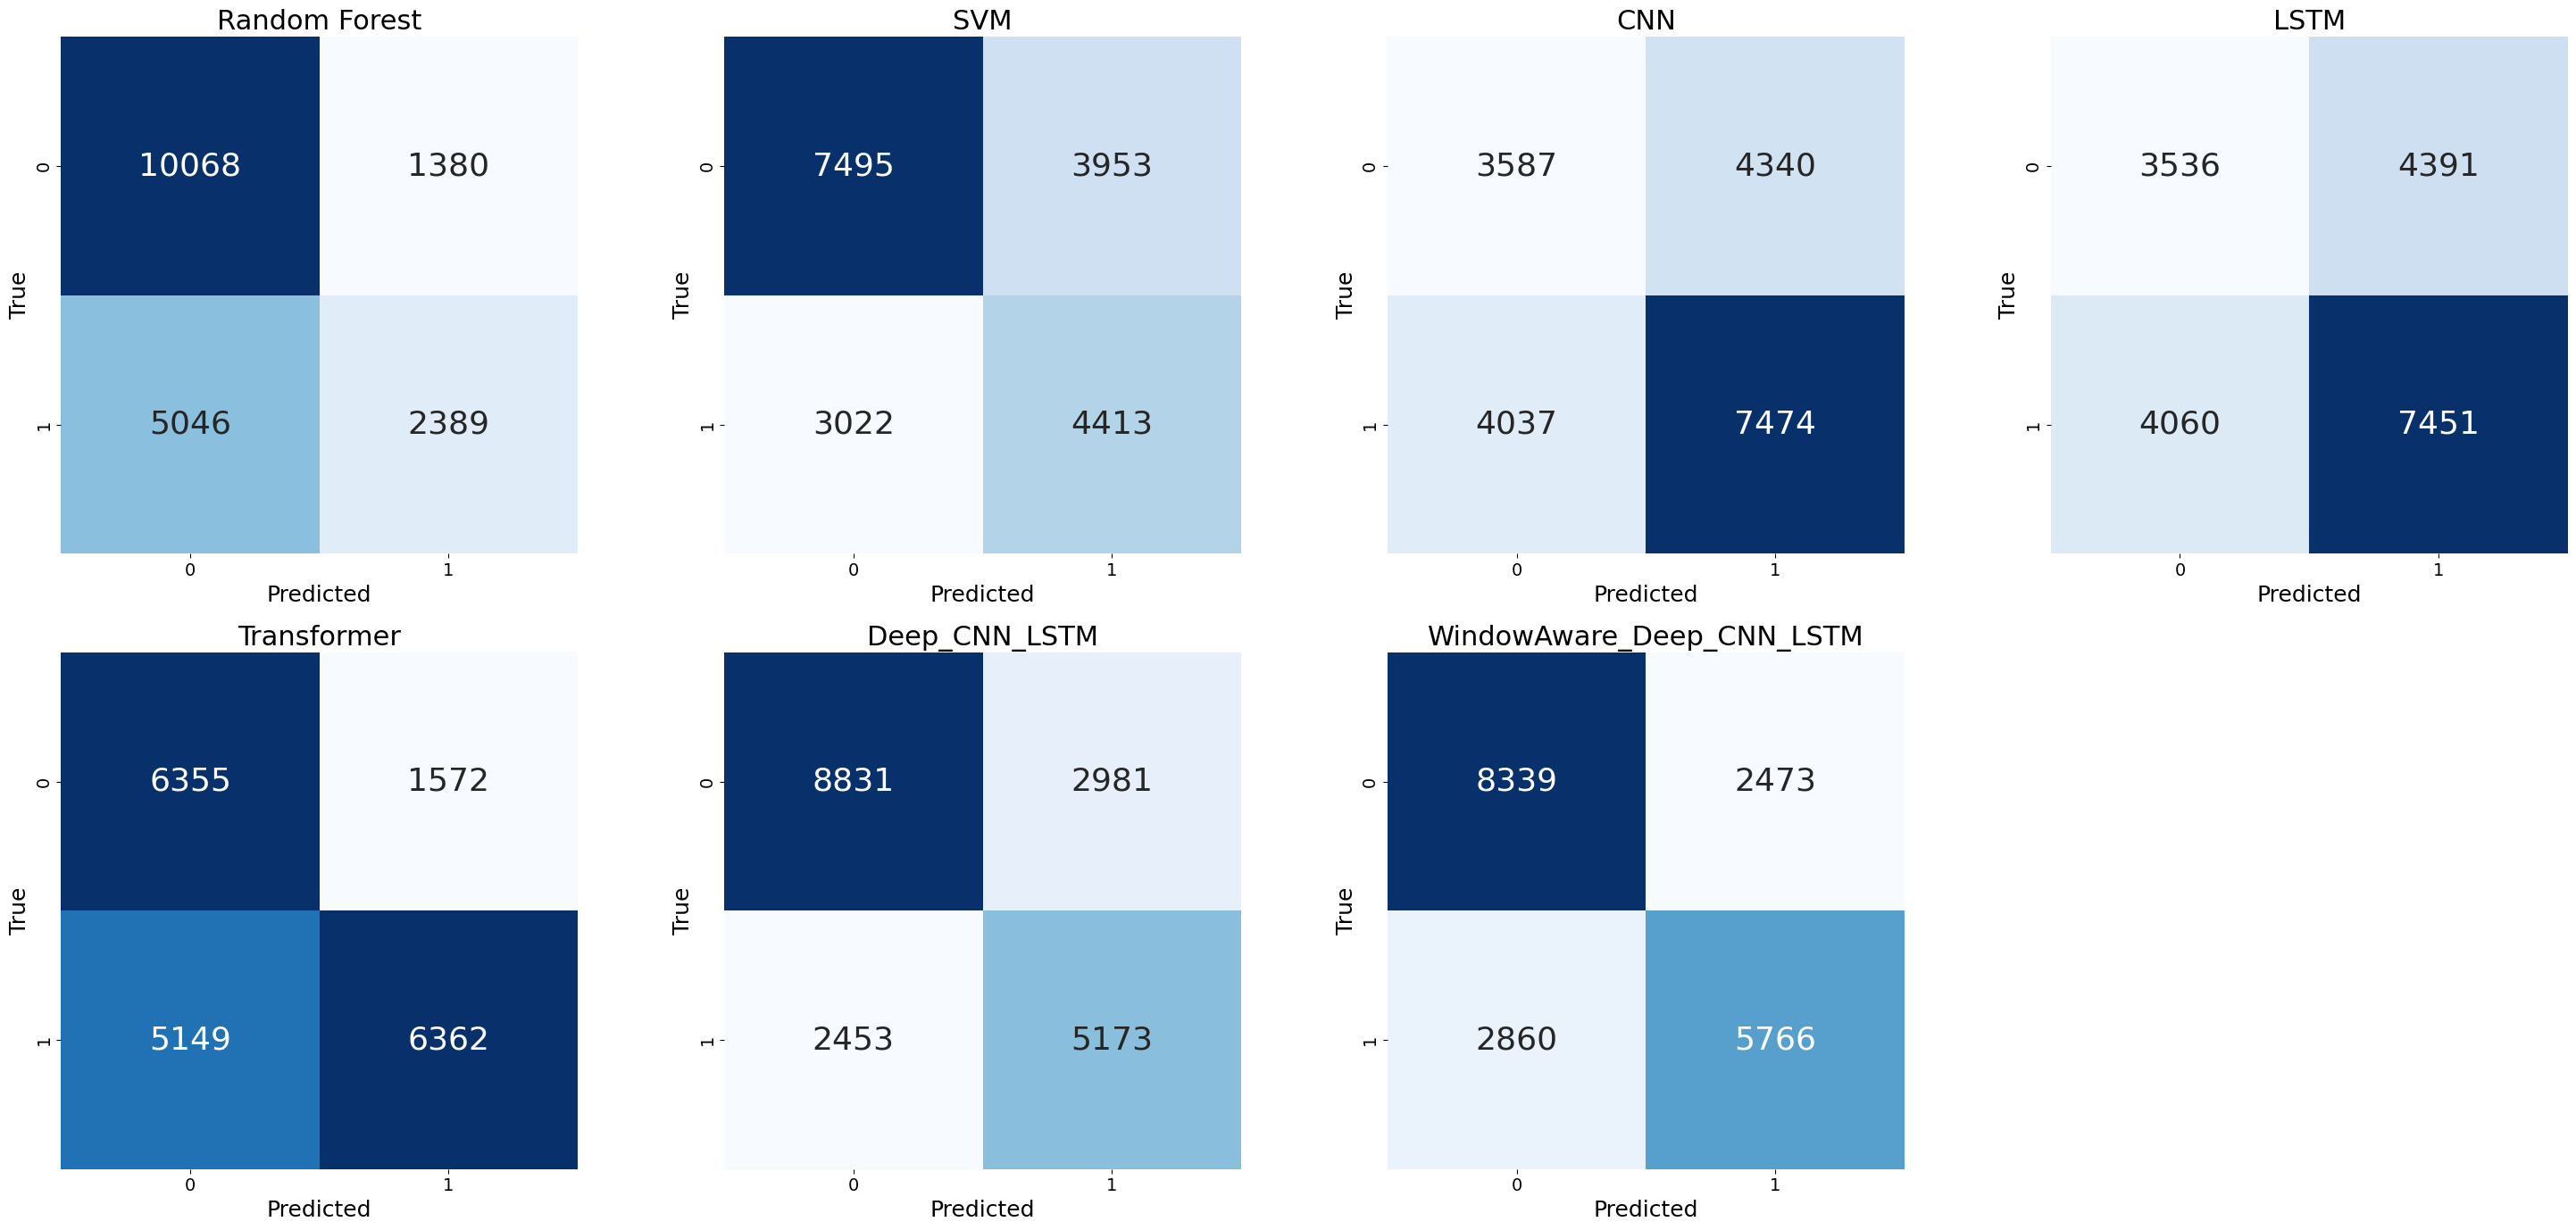

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define confusion matrices for all models
cm_data = {
    "Random Forest": np.array([[10068, 1380],
                               [5046, 2389]]),

    "SVM": np.array([[7495, 3953],
                     [3022, 4413]]),

    "CNN": np.array([[3587, 4340],
                     [4037, 7474]]),

    "LSTM": np.array([[3536, 4391],
                      [4060, 7451]]),

    "Transformer": np.array([[6355, 1572],
                             [5149, 6362]]),

    "Deep_CNN_LSTM": np.array([[8831, 2981],
                               [2453, 5173]])
}

# Add Window-Aware CNN-LSTM entry
cm_data["WindowAware_Deep_CNN_LSTM"] = np.array([
    [8339, 2473],
    [2860, 5766]
])

models = list(cm_data.keys())

# Layout: 4 models in row 1, 3 in row 2
rows = 2
cols = 4  # create 8 slots; last one will be deleted
fig, axes = plt.subplots(rows, cols, figsize=(30, 14))
axes = axes.flatten()

# Plot confusion matrices
for i, model in enumerate(models):
    sns.heatmap(cm_data[model], annot=True, fmt='d', ax=axes[i],
                cmap="Blues", cbar=False, annot_kws={"size": 26})

    axes[i].set_xlabel('Predicted', fontsize=18)
    axes[i].set_ylabel('True', fontsize=18)
    axes[i].set_title(model, fontsize=22)
    axes[i].tick_params(axis='x', labelsize=14)
    axes[i].tick_params(axis='y', labelsize=14)

    # Make each heatmap square
    axes[i].set_aspect("equal")

# Remove extra unused subplot (8th panel)
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()




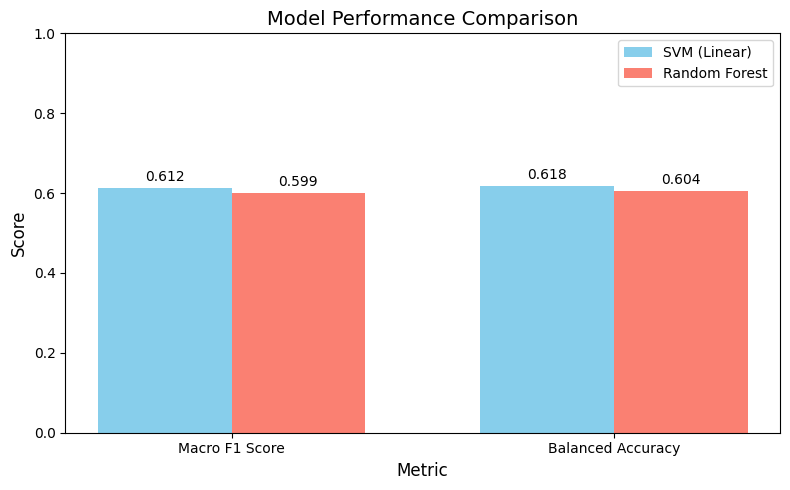

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and models
metrics = ['Macro F1 Score', 'Balanced Accuracy']
models = ['SVM (Linear)', 'Random Forest']

# Scores for each model
scores = {
    'SVM (Linear)': [0.612, 0.618],
    'Random Forest': [0.599, 0.604]
}

# Bar width
bar_width = 0.35
index = np.arange(len(metrics))

# Plot bars
fig, ax = plt.subplots(figsize=(8,5))

bars_svm = ax.bar(index - bar_width/2, scores['SVM (Linear)'], bar_width, label='SVM (Linear)', color='skyblue')
bars_rf = ax.bar(index + bar_width/2, scores['Random Forest'], bar_width, label='Random Forest', color='salmon')

# Labels and title
ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14)
ax.set_xticks(index)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)  # y-axis range

# Add value labels on top of bars
for bars in [bars_svm, bars_rf]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

ax.legend()
plt.tight_layout()
plt.show()


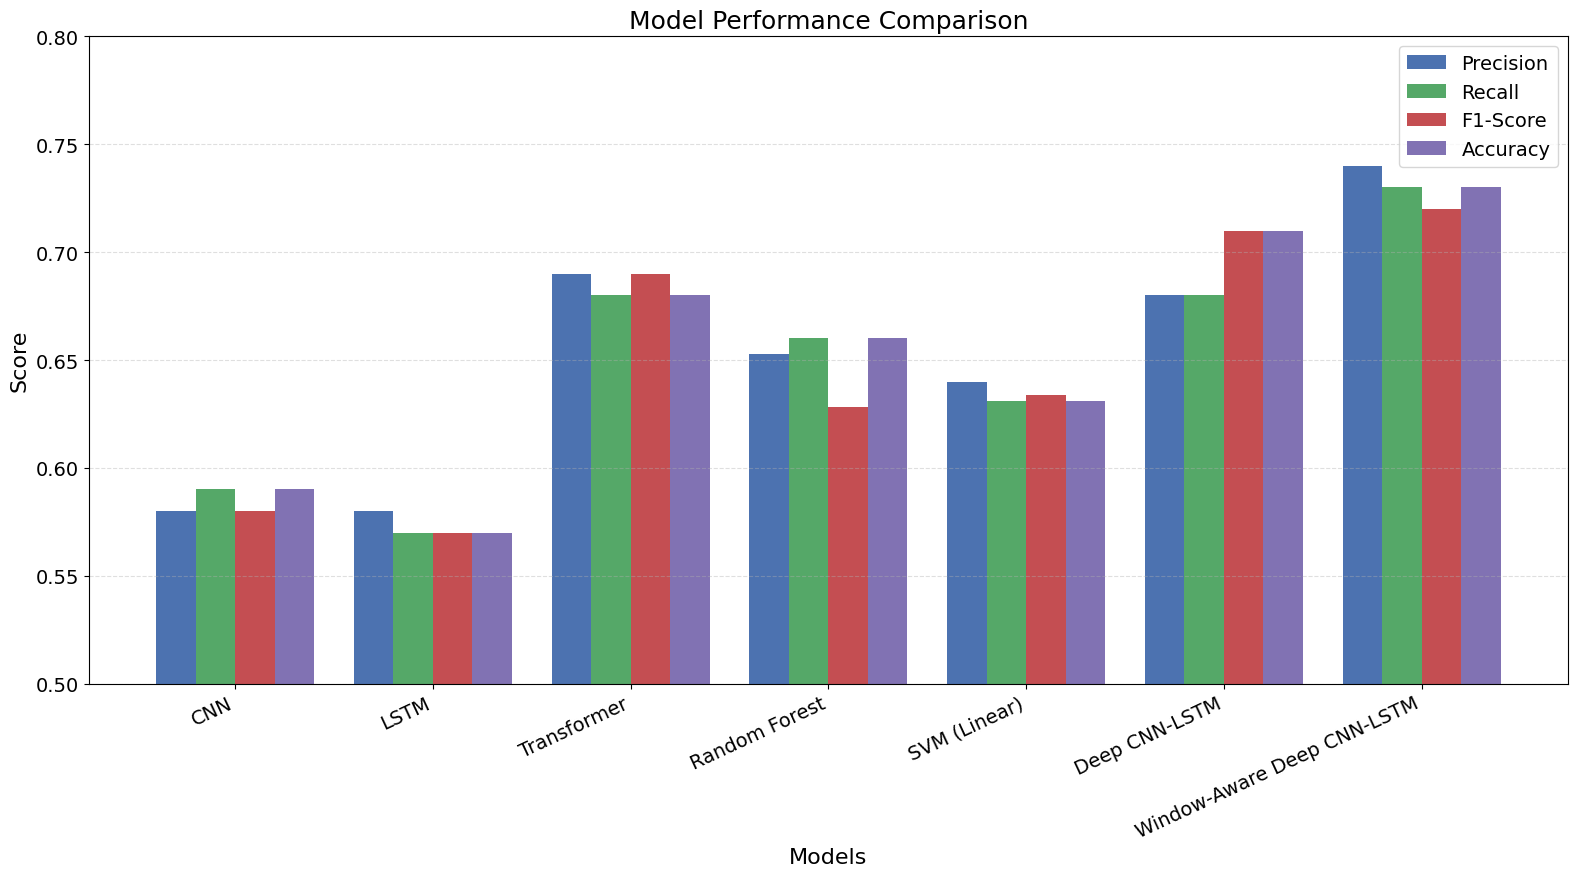

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = [
    "CNN", 
    "LSTM", 
    "Transformer", 
    "Random Forest", 
    "SVM (Linear)",
    "Deep CNN-LSTM",
    "Window-Aware Deep CNN-LSTM"
]
"""eep CNN–LSTM 0.680 0.680 0.710 0.713
Window-Aware Deep CNN–LSTM 0.740 0.730 0.728 0.731
"""
precision = [0.58, 0.58, 0.69, 0.653, 0.640, 0.68, 0.74]
recall    = [0.59, 0.57, 0.68, 0.660, 0.631, 0.68, 0.73]
f1_score  = [0.58, 0.57, 0.69, 0.628, 0.634, 0.71, 0.72]
accuracy  = [0.59, 0.57, 0.68, 0.660, 0.631, 0.71, 0.73]

# Plot setup
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 14})

# Bars
plt.bar(x - 1.5*width, precision, width, label='Precision', color='#4C72B0')
plt.bar(x - 0.5*width, recall,    width, label='Recall', color='#55A868')
plt.bar(x + 0.5*width, f1_score,  width, label='F1-Score', color='#C44E52')
plt.bar(x + 1.5*width, accuracy,  width, label='Accuracy', color='#8172B3')

# Labels and styling
plt.xlabel("Models", fontsize=16)
plt.ylabel("Score", fontsize=16)
plt.title("Model Performance Comparison", fontsize=18)
plt.xticks(x, models, rotation=25, ha='right')
plt.ylim(0.5, 0.8)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()
"""
# Annotate bars with values
for i in range(len(x)):
    for j, metric in enumerate([precision, recall, f1_score, accuracy]):
        plt.text(x[i] + (j-1.5)*width, metric[i]+0.005, f"{metric[i]:.2f}", 
                 ha='center', va='bottom', fontsize=10)"""

plt.show()


In [ ]:
"""
deep_cnn_lstm
confusion_matrix": [
        [
          8831,
          2981
        ],
        [
          2453,
          5173
        ]
        
window_aware_deep_cnn_lstm 
"confusion_matrix": [
        [
          9457,
          2355
        ],
        [
          2257,
          5369
        ]
"""